In [1]:
import os
import yaml
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt

LABELS_PATH="labels.yaml"
IMAGES_BASE="/workspaces/motion/images/good"

2023-01-15 16:55:52.504058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 16:55:53.075848: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11.3/targets/x86_64-linux/lib
2023-01-15 16:55:53.075924: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidi

In [2]:
tf.config.list_physical_devices()

2023-01-15 16:55:53.824365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 16:55:53.828443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 16:55:53.828630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
with open(LABELS_PATH) as f:
    label_map = yaml.load(f, Loader=yaml.SafeLoader)["labels"]
reverse_label_map = {v:k for k,v in label_map.items()}

labels = []
for dir,subdirs,files in os.walk(IMAGES_BASE):
    label = os.path.basename(dir)
    subdirs.sort()
    files.sort()
    for file in files:
        fullpath = os.path.join(dir, file)
        labels.append(label_map[label])

ds = tf.keras.utils.image_dataset_from_directory(
    IMAGES_BASE,
    labels=labels,
    label_mode="int",
    color_mode="grayscale",
    batch_size=10,
    image_size=(40, 40),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
val_ds = ds.take(10)
test_ds = ds.skip(10).take(10)
train_ds = ds.skip(20)

Found 1181 files belonging to 7 classes.


2023-01-15 16:55:53.931821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 16:55:53.932991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 16:55:53.933174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-15 16:55:53.933322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

In [4]:
tf.debugging.set_log_device_placement(True)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(4, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
)

Epoch 1/30


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-01-15 16:55:55.268627: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-15 16:55:55.811369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-01-15 16:55:56.331842: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6514c40d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-15 16:55:56.331869: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 208

99/99 [==============================] - 3s 6ms/step - loss: 12.0857 - accuracy: 0.5556 - val_loss: 0.9738 - val_accuracy: 0.8300
Epoch 2/30
99/99 [==============================] - 0s 4ms/step - loss: 1.8453 - accuracy: 0.7339 - val_loss: 0.3920 - val_accuracy: 0.8800
Epoch 3/30
99/99 [==============================] - 0s 4ms/step - loss: 1.0968 - accuracy: 0.7808 - val_loss: 0.6661 - val_accuracy: 0.8300
Epoch 4/30
99/99 [==============================] - 0s 4ms/step - loss: 0.7572 - accuracy: 0.8277 - val_loss: 0.4420 - val_accuracy: 0.8700
Epoch 5/30
99/99 [==============================] - 0s 4ms/step - loss: 0.5206 - accuracy: 0.8573 - val_loss: 0.3260 - val_accuracy: 0.9100
Epoch 6/30
99/99 [==============================] - 0s 4ms/step - loss: 0.5282 - accuracy: 0.8624 - val_loss: 0.2575 - val_accuracy: 0.9400
Epoch 7/30
99/99 [==============================] - 0s 4ms/step - loss: 0.3416 - accuracy: 0.9083 - val_loss: 0.3110 - val_accuracy: 0.9200
Epoch 8/30
99/99 [============

(40, 40)


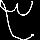

(1, 40, 40)
1/1 [==============================] - 0s 14ms/step
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000']
1.0
tarantallegra


In [42]:
img_array = [i for i in test_ds][0][0][0]
array_shaped = img_array.numpy().reshape(40,40)
print(array_shaped.shape)
display(Image.fromarray(array_shaped).convert("RGB"))
print(np.expand_dims(np.squeeze(img_array), axis=0).shape)
r = model.predict(np.expand_dims(np.squeeze(img_array), axis=0))
print([f"{i:.4f}" for i in r[0]])
print(np.max(r))
raw_pred = tf.argmax(r, 1).numpy()[0]
print(reverse_label_map[raw_pred])

images/good/crap/2660.png


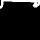

1/1 [==============================] - 0s 49ms/step
['0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000']
1.0
crap


In [6]:
random_path = os.path.join('images/good/crap', random.sample(os.listdir('images/good/crap'), k=1)[0])
print(random_path)
i = Image.open(random_path)
display(i)
img_array = np.asarray(i, dtype=np.uint8).reshape(40,40, 1)
formatted_img_array = np.expand_dims(img_array, axis=0)
r = model.predict(formatted_img_array)
print([f"{i:.4f}" for i in r[0]])
print(np.max(r))
raw_pred = tf.argmax(r, 1).numpy()[0]
print(reverse_label_map[raw_pred])


1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'Confusion Matrix')

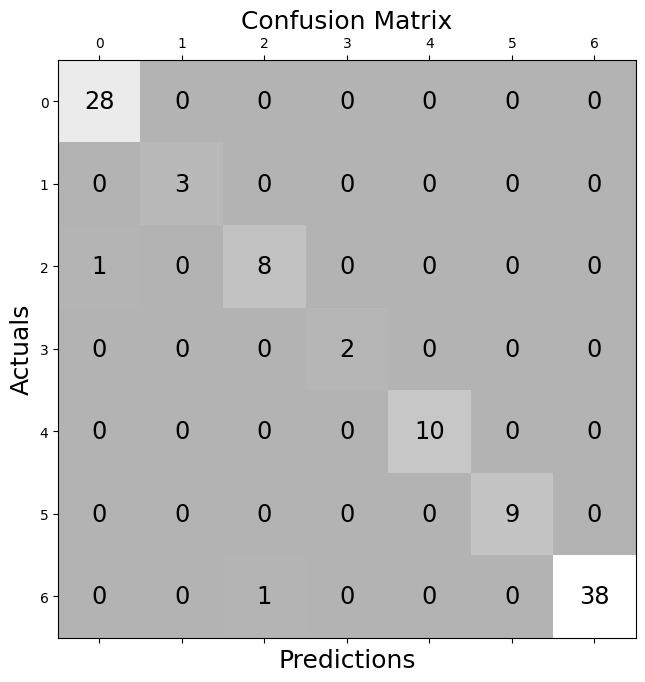

In [96]:
real_classes = []
pred_classes = []

for batch in test_ds:
    preds = model.predict(batch[0])
    pred_classes.extend(tf.argmax(preds, 1).numpy())
    real_classes.extend(batch[1].numpy())

conf_matrix = tf.math.confusion_matrix(real_classes, pred_classes)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.gray, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j].numpy(), va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

In [98]:
model.save("output")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67001a2370>, 140082238381392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67001a2370>, 140082238381392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670015d640>, 140082238351472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670015d640>, 140082238351472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700162e20>, 140082237806192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700162e20>, 140082237806192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670010eac0>, 140082237806112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670010eac0>, 140082237806112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1600, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700123a30>, 140082237858800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1600, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700123a30>, 140082237858800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700137a60>, 140082238196208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700137a60>, 140082238196208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000cb9d0>, 140082237860320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000cb9d0>, 140082237860320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000dda00>, 140082237860800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000dda00>, 140082237860800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67001a2370>, 140082238381392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67001a2370>, 140082238381392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670015d640>, 140082238351472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670015d640>, 140082238351472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700162e20>, 140082237806192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 4, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700162e20>, 140082237806192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670010eac0>, 140082237806112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f670010eac0>, 140082237806112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1600, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700123a30>, 140082237858800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1600, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700123a30>, 140082237858800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700137a60>, 140082238196208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f6700137a60>, 140082238196208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000cb9d0>, 140082237860320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000cb9d0>, 140082237860320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000dda00>, 140082237860800), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f67000dda00>, 140082237860800), {}).


INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets
